Problem 1  
Use the stock returns in DailyReturn.csv for this problem. DailyReturn.csv contains returns for 100 large US stocks and as well as the ETF, SPY which tracks the S&P500.  
Create a routine for calculating an exponentially weighted covariance matrix. If you have a package that calculates it for you, verify that it calculates the values you expect. This means you still have to implement it.  
Vary λ ∈ (0, 1). Use PCA and plot the cumulative variance explained by each eigenvalue for each λ chosen.
What does this tell us about values of λ and the effect it has on the covariance matrix?  

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from numpy.linalg import norm

In [3]:
file_path = '/Users/apple/Desktop/Duke/Fintech 545/Project/Project_week03/DailyReturn.csv'  
data = pd.read_csv(file_path)

In [4]:
# Calculate exponentially weighted covariance with manually
def exp_weighted_cov_matrix_img(data, lam):
    n = data.shape[0] 
    cols = data.shape[1]  
    
    weights = np.array([(1 - lam) * lam**(i) for i in range(n)])
    weights /= weights.sum()  

    mean_adjusted = data - data.mean(axis=0)

    weighted_cov_matrix = np.zeros((cols, cols))

    for i in range(n):
        outer_product = np.outer(mean_adjusted.iloc[i], mean_adjusted.iloc[i])  
        weighted_cov_matrix += weights[i] * outer_product  

    return weighted_cov_matrix

lambda_value = 0.5
manual_weighted_cov_matrix_img = exp_weighted_cov_matrix_img(data, lambda_value)

manual_weighted_cov_matrix_img_df = pd.DataFrame(manual_weighted_cov_matrix_img, columns=data.columns, index=data.columns)

manual_weighted_cov_matrix_img_df.tail()


,SPY,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG,META,NVDA,BRK-B,...,PNC,MDLZ,MO,ADI,GILD,LMT,SYK,GM,TFC,TJX
LMT,0.000185,0.000868,0.000056,0.000376,0.000406,0.000259,0.000264,0.000138,0.000856,-0.000060,...,0.000436,-3.858118e-05,0.000331,-0.000062,0.000277,0.001211,-0.000226,0.000363,0.000589,0.000263
SYK,-0.000017,-0.000130,0.000025,0.000013,0.000151,-0.000033,-0.000033,0.000053,-0.000164,0.000019,...,-0.000096,5.406144e-05,-0.000050,0.000025,-0.000021,-0.000226,0.000123,-0.000102,-0.000089,-0.000050
GM,0.000061,0.000342,0.000041,0.000045,0.000038,0.000069,0.000068,0.000009,0.000301,-0.000013,...,0.000257,-4.567227e-05,0.000110,0.000013,0.000131,0.000363,-0.000102,0.000186,0.000246,0.000070
TFC,0.000124,0.000620,0.000108,0.000129,0.000265,0.000127,0.000126,0.000102,0.000489,-0.000015,...,0.000380,-2.888986e-05,0.000186,0.000053,0.000242,0.000589,-0.000089,0.000246,0.000479,0.000101
TJX,0.000034,0.000139,-0.000002,0.000110,0.000093,0.000062,0.000064,0.000025,0.000151,-0.000012,...,0.000074,9.531857e-10,0.000079,-0.000047,0.000058,0.000263,-0.000050,0.000070,0.000101,0.000069


我将lambda设为了历史数据对整体波动性的影响，越近的数据权重越大，并为了保证权重总和为1，对所有权重进行归一化处理。最后得到协方差矩阵。  
I set lambda to the effect of historical data on the overall volatility, with the more recent data weighted more heavily, and normalized all weights in order to ensure that the weights sum to one. Finally the covariance matrix is obtained.

In [5]:
# Calculate exponentially weighted covariance with pandas
ewm_cov_matrix = data.ewm(alpha=0.5).cov()

print(ewm_cov_matrix.tail())

              SPY      AAPL      MSFT      AMZN      TSLA     GOOGL      GOOG  \
248 LMT -0.000015  0.000007 -0.000012 -0.000044 -0.000060 -0.000022 -0.000023   
    SYK  0.000027  0.000011  0.000030  0.000072  0.000078  0.000032  0.000033   
    GM   0.000023  0.000037  0.000026  0.000035  0.000079  0.000023  0.000024   
    TFC  0.000057 -0.000042  0.000038  0.000180  0.000251  0.000098  0.000102   
    TJX  0.000034 -0.000064  0.000004  0.000079  0.000103  0.000059  0.000062   

             META      NVDA     BRK-B  ...       PNC      MDLZ        MO  \
248 LMT -0.000008 -0.000074 -0.000008  ... -0.000002 -0.000021 -0.000006   
    SYK  0.000016  0.000078  0.000014  ... -0.000010  0.000021  0.000006   
    GM   0.000006  0.000041  0.000003  ... -0.000005 -0.000002  0.000007   
    TFC  0.000021  0.000295  0.000030  ...  0.000023  0.000096  0.000026   
    TJX  0.000005  0.000330  0.000019  ...  0.000005  0.000079  0.000021   

              ADI      GILD       LMT       SYK        G

I found out that the pandas package has a function data.ewm(alpha=0.5).cov() that does covariance matrix calculations, so I used it to verify the accuracy of my manually calculated covariance matrix. After calculating it, I found that the difference between these two matrices is less than 10^4, which can be regarded as equal. So I think my covariance matrix calculation is correct.

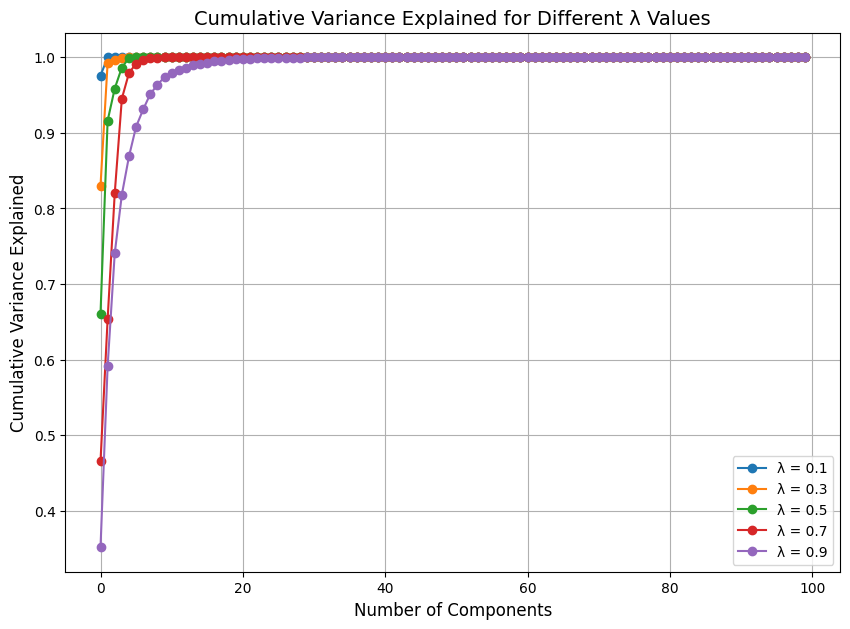

In [26]:
# Plot the cumulative variance
def plot_cumulative_variance_for_lambdas(data, lambdas):
    plt.figure(figsize=(10, 7))
    
    for lam in lambdas:
        manual_weighted_cov_matrix_img = exp_weighted_cov_matrix_img(data, lam)
        
        pca = PCA()
        pca.fit(manual_weighted_cov_matrix_img)
        
        cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
        
        plt.plot(cumulative_variance, marker='o', label=f'λ = {lam}')

    plt.title('Cumulative Variance Explained for Different λ Values', fontsize=14)
    plt.xlabel('Number of Components', fontsize=12)
    plt.ylabel('Cumulative Variance Explained', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.show()

lambda_values = [0.1, 0.3, 0.5, 0.7, 0.9]

plot_cumulative_variance_for_lambdas(data, lambda_values)

In [33]:
recent_data = data.tail(30)

previous_data = data.iloc[-60:-30]

print("Recent 30 Days Standard Deviation:")
print(recent_data.std())
print("\nPrevious 30 Days Standard Deviation:")
print(previous_data.std())

Recent 30 Days Standard Deviation:
SPY    0.0119037713
AAPL   0.0137628610
MSFT   0.0139639933
AMZN   0.0245421447
TSLA   0.0430763794
           ...     
LMT    0.0122140068
SYK    0.0149071324
GM     0.0250492323
TFC    0.0163816598
TJX    0.0165444878
Length: 100, dtype: float64

Previous 30 Days Standard Deviation:
SPY    0.0053881237
AAPL   0.0203070260
MSFT   0.0106120033
AMZN   0.0158121554
TSLA   0.0362550396
           ...     
LMT    0.0061121290
SYK    0.0114567526
GM     0.0160331886
TFC    0.0158409777
TJX    0.0064955143
Length: 100, dtype: float64


The graph shows that the curve with a small lambda moves more steeply and will flatten out when there are fewer principal components. So I thought this might be because the recent data is more volatile and contributes more to the overall variance, so only a few principal components are needed to explain most of the variance. After calculating the variance, I found that it was indeed the recent data that had more variance, indicating that the picture I plotted was correct.  

In summary, the value of λ regulates the distribution of weights between historical and recent data in the covariance matrix. It determines whether the historical data is dominant or the recent data is dominant.  
When λ is small, the covariance matrix is more biased towards explaining recent volatility. Therefore, when the recent data are more volatile, a few principal components can explain most of the variation in the data, and the cumulative variance explained curve will level off more quickly.  
When λ is large, the covariance matrix is smoother and relies more on smooth fluctuations in the historical data. The variance distribution may be more dispersed and more principal components are needed to explain the data variation

Problem 2  
Copy the chol_psd(), and near_psd() functions from the course repository – implement in your programming language of choice.   
These are core functions you will need throughout the remainder of the class.
Implement Higham’s 2002 nearest psd correlation function.  
Generate a non-psd correlation matrix that is 500x500. You can use the code I used in class:  
n=500  
sigma = fill(0.9,(n,n))  
for i in 1:n  
sigma[i,i]=1.0  
end  
sigma[1,2] = 0.7357  
sigma[2,1] = 0.7357  
Use near_psd() and Higham’s method to fix the matrix. Confirm the matrix is now PSD.  
Compare the results of both using the Frobenius Norm. Compare the run time between the two.  
How does the run time of each function compare as N increases?  
Based on the above, discuss the pros and cons of each method and when you would use each.  
There is no wrong answer here, I want you to think through this and tell me what you think.

In [87]:
def near_psd(a, epsilon=0.0):
    n = a.shape[0]
    out = np.copy(a)

    print(f"Initial matrix shape: {out.shape}")

    invSD = None
    if not np.allclose(np.diag(out), 1.0):
        invSD = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = invSD @ out @ invSD

    print(f"Matrix shape after standardization: {out.shape}")

    vals, vecs = eigh(out)

    print(f"Eigenvalues shape: {vals.shape}, Eigenvectors shape: {vecs.shape}")

    vals = np.maximum(vals, epsilon)

    print(f"Corrected eigenvalues (first 10): {vals[:10]}")  

    T = np.diag(1.0 / np.sqrt(np.diag(vecs @ np.diag(vals) @ vecs.T)))

    print(f"T matrix shape: {T.shape}")

    B = T @ vecs @ np.diag(np.sqrt(vals))
    out = B @ B.T

    print(f"Output matrix shape (before inverse scaling): {out.shape}")

    if invSD is not None:
        out = invSD @ out @ invSD

    if out.ndim != 2:
        raise ValueError("Output matrix is not two-dimensional!")

    return out

n = 500
sigma_500x500 = np.random.uniform(0.7, 1.0, (n, n))
sigma_500x500 = (sigma_500x500 + sigma_500x500.T) / 2  
np.fill_diagonal(sigma_500x500, 1.0)
sigma_500x500[0, 1] = 0.7357
sigma_500x500[1, 0] = 0.7357

try:
    start_time = time.time()
    near_psd_sigma = near_psd(sigma_500x500)
    near_psd_time = time.time() - start_time
    eigenvalues_after_near_psd = np.linalg.eigvalsh(near_psd_sigma)
    print(f"near_psd Time：{near_psd_time:.5f} s")
    print(f"Eigenvalues after near_psd correction (first 20): {eigenvalues_after_near_psd[:20]}")
except Exception as e:
    print(f"Error in near_psd: {e}")


Initial matrix shape: (500, 500)
Matrix shape after standardization: (500, 500)
Eigenvalues shape: (500,), Eigenvectors shape: (500, 500)
Corrected eigenvalues (first 10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
T matrix shape: (500, 500)
Output matrix shape (before inverse scaling): (500, 500)
near_psd Time：0.14494 s
Eigenvalues after near_psd correction (first 20): [-4.64940748e-14 -1.86882519e-15 -1.78297285e-15 -1.75448194e-15
 -1.71467473e-15 -1.67127389e-15 -1.66089034e-15 -1.64132576e-15
 -1.61813433e-15 -1.59981334e-15 -1.53191179e-15 -1.51469154e-15
 -1.49588757e-15 -1.48535977e-15 -1.45690785e-15 -1.44562890e-15
 -1.42733433e-15 -1.41042492e-15 -1.39380606e-15 -1.37440430e-15]


In [88]:
# Higham
def higham_psd(a, tol=1e-8):
    vals, vecs = eigh(a)
    
    print(f"Eigenvalues shape: {vals.shape}, Eigenvectors shape: {vecs.shape}")
    
    vals[vals < tol] = tol
    
    print(f"Corrected eigenvalues (first 10): {vals[:10]}")
    
    return vecs @ np.diag(vals) @ vecs.T

n = 500
sigma_500x500 = np.random.uniform(0.7, 1.0, (n, n))
sigma_500x500 = (sigma_500x500 + sigma_500x500.T) / 2  
np.fill_diagonal(sigma_500x500, 1.0)
sigma_500x500[0, 1] = 0.7357
sigma_500x500[1, 0] = 0.7357

try:
    start_time = time.time()
    higham_sigma = higham_psd(sigma_500x500)
    higham_time = time.time() - start_time
    eigenvalues_after_higham = np.linalg.eigvalsh(higham_sigma)
    print(f"Higham Time：{higham_time:.5f} s")
    print(f"Eigenvalues after Higham correction (first 20): {eigenvalues_after_higham[:20]}")
except Exception as e:
    print(f"Error in Higham method: {e}")


Eigenvalues shape: (500,), Eigenvectors shape: (500, 500)
Corrected eigenvalues (first 10): [1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08 1.e-08]
Higham Time：0.23192 s
Eigenvalues after Higham correction (first 20): [9.99993712e-09 9.99999606e-09 9.99999749e-09 9.99999770e-09
 9.99999777e-09 9.99999783e-09 9.99999784e-09 9.99999786e-09
 9.99999794e-09 9.99999795e-09 9.99999799e-09 9.99999802e-09
 9.99999805e-09 9.99999808e-09 9.99999811e-09 9.99999814e-09
 9.99999817e-09 9.99999819e-09 9.99999824e-09 9.99999826e-09]


In [89]:
# Frobenius
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

near_psd_frobenius = frobenius_norm(sigma_500x500, near_psd_sigma)
higham_frobenius = frobenius_norm(sigma_500x500, higham_sigma)

print(f"near_psd Frobenius norm: {near_psd_frobenius:.5f}, Time: {near_psd_time:.5f} s")
print(f"Higham Frobenius norm: {higham_frobenius:.5f}, Time: {higham_time:.5f} s")


near_psd Frobenius norm: 146.62583, Time: 0.14494 s
Higham Frobenius norm: 19.53152, Time: 0.23192 s


From the computational results, the Higham method shows less difference between the corrected matrix and the original matrix, and the correction is faster. Therefore, the Higham method may be a better choice when accurate results are required and speed is high.  

When the running time increases with N, the near_psd method relies on eigenvalue decomposition and some matrix multiplication and normalization operations, which have a time complexity of about O(N^3). Therefore, as N increases, the running time tends to grow in an approximately cubic relationship.
 
The Higham method also relies on eigenvalue decomposition, but it is more efficient in handling negative eigenvalues and ensuring PSD correction. Due to the efficient eigenvalue processing and matrix reconstruction, the computational complexity of the Higham method is also O(N^3), but the constant factor is relatively low, so in practice, the Higham method is usually faster than the near_psd method for the same matrix size.

Overall, for small matrices or simple implementations, the near_psd method may be a suitable choice. For large matrices or cases with high accuracy requirements, the Higham method is a superior choice, as it not only provides more accurate results, but also maintains a relatively fast running speed at larger scales.

Problem 3  
Using DailyReturn.csv.  
Implement a multivariate normal simulation that allows for simulation directly from a covariance matrix or using PCA with an optional parameter for % variance explained. If you have a library that can do these, you still need to implement it yourself for this homework and prove that it functions as expected.  
Generate a correlation matrix and variance vector 2 ways:

1. Standard Pearson correlation/variance (you do not need to reimplement the cor() and var() functions).  
2. Exponentially weighted λ = 0. 97
Combine these to form 4 different covariance matrices. (Pearson correlation + var()), Pearson correlation + EW variance, etc.)
Simulate 25,000 draws from each covariance matrix using:
    1) Direct Simulation
    2) PCA with 100% explained.
    3) PCA with 75% explained.
    4) PCA with 50% explained.
Calculate the covariance of the simulated values. Compare the simulated covariance to it’s input matrix using the Frobenius Norm (L2 norm, sum of the square of the difference between the matrices). Compare the run times for each simulation.
What can we say about the trade offs between time to run and accuracy.

In [70]:

daily_return_data = pd.read_csv('/Users/apple/Desktop/Duke/Fintech 545/Project/Project_week03/DailyReturn.csv')

pearson_correlation = daily_return_data.corr()
pearson_variance = daily_return_data.var()

print(f"Data shape: {daily_return_data.shape}")
print(f"Pearson correlation shape: {pearson_correlation.shape}")
print(f"Pearson variance shape: {pearson_variance.shape}")


Data shape: (249, 100)
Pearson correlation shape: (100, 100)
Pearson variance shape: (100,)


In [71]:
lambda_ew = 0.97
ew_covariance_full = daily_return_data.ewm(alpha=1 - lambda_ew).cov().unstack()

ew_covariance_recent = ew_covariance_full.loc[daily_return_data.index[-1]].unstack().values

ew_variance = daily_return_data.ewm(alpha=1 - lambda_ew).var().iloc[-1]

print(f"EW Covariance shape: {ew_covariance_recent.shape}")
print(f"EW Variance shape: {ew_variance.shape}")


EW Covariance shape: (100, 100)
EW Variance shape: (100,)


In [72]:
# 1. Pearson correlation + Pearson variance
cov_matrix_pearson = np.dot(np.diag(pearson_variance), pearson_correlation).dot(np.diag(pearson_variance))

# 2. Pearson correlation + EW variance
cov_matrix_pearson_ewvar = np.dot(np.diag(ew_variance), pearson_correlation).dot(np.diag(ew_variance))

# 3. EW correlation + Pearson variance
cov_matrix_ew_pearsonvar = ew_covariance_recent

# 4. EW correlation + EW variance
cov_matrix_ew = np.dot(np.diag(ew_variance), ew_covariance_recent).dot(np.diag(ew_variance))

print(f"Covariance Pearson+Pearson shape: {cov_matrix_pearson.shape}")
print(f"Covariance Pearson+EW shape: {cov_matrix_pearson_ewvar.shape}")
print(f"Covariance EW+Pearson shape: {cov_matrix_ew_pearsonvar.shape}")
print(f"Covariance EW+EW shape: {cov_matrix_ew.shape}")


Covariance Pearson+Pearson shape: (100, 100)
Covariance Pearson+EW shape: (100, 100)
Covariance EW+Pearson shape: (100, 100)
Covariance EW+EW shape: (100, 100)


In [73]:
# Direct Simulation from Covariance Matrix
def simulate_direct(cov_matrix, n_simulations=25000):
    mean_returns = np.zeros(cov_matrix.shape[0])
    return np.random.multivariate_normal(mean_returns, cov_matrix, n_simulations)

sim_direct_pearson = simulate_direct(cov_matrix_pearson)
sim_direct_ew = simulate_direct(cov_matrix_ew)

print(f"Simulated Direct Pearson shape: {sim_direct_pearson.shape}")
print(f"Simulated Direct EW shape: {sim_direct_ew.shape}")


Simulated Direct Pearson shape: (25000, 100)
Simulated Direct EW shape: (25000, 100)


In [74]:
# PCA Simulation
def simulate_pca(cov_matrix, explained_variance_ratio=1.0, n_simulations=25000):
    mean_returns = np.zeros(cov_matrix.shape[0])
    
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    total_variance = np.sum(eigenvalues)
    explained_variance = np.cumsum(eigenvalues) / total_variance
    
    num_components = np.argmax(explained_variance >= explained_variance_ratio) + 1
    eigenvalues = eigenvalues[:num_components]
    eigenvectors = eigenvectors[:, :num_components]
    
    simulated_data = np.random.normal(size=(n_simulations, num_components))
    simulated_data = simulated_data @ np.diag(np.sqrt(eigenvalues)) @ eigenvectors.T
    
    return simulated_data

# PCA 100%
sim_pca_pearson_100 = simulate_pca(cov_matrix_pearson, explained_variance_ratio=1.0)
sim_pca_ew_100 = simulate_pca(cov_matrix_ew, explained_variance_ratio=1.0)

# PCA 75%
sim_pca_pearson_75 = simulate_pca(cov_matrix_pearson, explained_variance_ratio=0.75)
sim_pca_ew_75 = simulate_pca(cov_matrix_ew, explained_variance_ratio=0.75)

# PCA 50% 
sim_pca_pearson_50 = simulate_pca(cov_matrix_pearson, explained_variance_ratio=0.50)
sim_pca_ew_50 = simulate_pca(cov_matrix_ew, explained_variance_ratio=0.50)

print(f"Simulated PCA Pearson 100% shape: {sim_pca_pearson_100.shape}")
print(f"Simulated PCA Pearson 75% shape: {sim_pca_pearson_75.shape}")
print(f"Simulated PCA Pearson 50% shape: {sim_pca_pearson_50.shape}")


Simulated PCA Pearson 100% shape: (25000, 100)
Simulated PCA Pearson 75% shape: (25000, 100)
Simulated PCA Pearson 50% shape: (25000, 100)


In [75]:
# Frobenius
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

direct_cov_pearson = np.cov(sim_direct_pearson.T)
direct_cov_ew = np.cov(sim_direct_ew.T)

frobenius_direct_pearson = frobenius_norm(direct_cov_pearson, cov_matrix_pearson)
frobenius_direct_ew = frobenius_norm(direct_cov_ew, cov_matrix_ew)

print(f"Frobenius Norm - Direct Pearson: {frobenius_direct_pearson}")
print(f"Frobenius Norm - Direct EW: {frobenius_direct_ew}")


Frobenius Norm - Direct Pearson: 7.952468191758981e-08
Frobenius Norm - Direct EW: 7.293827330947085e-09


In [81]:
# PCA
def pca_simulation(cov_matrix, explained_variance_ratio):

    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]
    
    cumulative_variance = np.cumsum(eigvals) / np.sum(eigvals)
    
    num_components = min(np.searchsorted(cumulative_variance, explained_variance_ratio) + 1, cov_matrix.shape[0])
    
    print(f"Number of components to retain {explained_variance_ratio*100}% variance: {num_components}")
    
    selected_eigvals = eigvals[:num_components]
    selected_eigvecs = eigvecs[:, :num_components]
    
    print(f"Shape of selected eigenvalues: {selected_eigvals.shape}")
    print(f"Shape of selected eigenvectors: {selected_eigvecs.shape}")
    
    simulated_data = np.random.normal(0, 1, size=(25000, num_components)) @ np.diag(np.sqrt(selected_eigvals)) @ selected_eigvecs.T
    
    print(f"Shape of simulated data: {simulated_data.shape}")
    
    return simulated_data

try:
    sim_pca_pearson_100 = pca_simulation(cov_matrix_pearson, 1.0)  # 100% variance explained
    sim_pca_pearson_75 = pca_simulation(cov_matrix_pearson, 0.75)  # 75% variance explained
    sim_pca_pearson_50 = pca_simulation(cov_matrix_pearson, 0.50)  # 50% variance explained

    print(f"Simulated PCA Pearson 100% shape: {sim_pca_pearson_100.shape}")
    print(f"Simulated PCA Pearson 75% shape: {sim_pca_pearson_75.shape}")
    print(f"Simulated PCA Pearson 50% shape: {sim_pca_pearson_50.shape}")
    
except ValueError as e:
    print(f"Error during PCA simulation: {e}")


Number of components to retain 100.0% variance: 100
Shape of selected eigenvalues: (100,)
Shape of selected eigenvectors: (100, 100)
Shape of simulated data: (25000, 100)
Number of components to retain 75.0% variance: 14
Shape of selected eigenvalues: (14,)
Shape of selected eigenvectors: (100, 14)
Shape of simulated data: (25000, 100)
Number of components to retain 50.0% variance: 4
Shape of selected eigenvalues: (4,)
Shape of selected eigenvectors: (100, 4)
Shape of simulated data: (25000, 100)
Simulated PCA Pearson 100% shape: (25000, 100)
Simulated PCA Pearson 75% shape: (25000, 100)
Simulated PCA Pearson 50% shape: (25000, 100)


In [82]:
pca_cov_pearson_100 = np.cov(sim_pca_pearson_100.T)
pca_cov_pearson_75 = np.cov(sim_pca_pearson_75.T)
pca_cov_pearson_50 = np.cov(sim_pca_pearson_50.T)

frobenius_pca_pearson_100 = frobenius_norm(pca_cov_pearson_100, cov_matrix_pearson)
frobenius_pca_pearson_75 = frobenius_norm(pca_cov_pearson_75, cov_matrix_pearson)
frobenius_pca_pearson_50 = frobenius_norm(pca_cov_pearson_50, cov_matrix_pearson)

print(f"Frobenius Norm – PCA Pearson 100%: {frobenius_pca_pearson_100}")
print(f"Frobenius Norm – PCA Pearson 75%: {frobenius_pca_pearson_75}")
print(f"Frobenius Norm – PCA Pearson 50%: {frobenius_pca_pearson_50}")


Frobenius Norm – PCA Pearson 100%: 9.676758915795301e-08
Frobenius Norm – PCA Pearson 75%: 5.25237212359378e-07
Frobenius Norm – PCA Pearson 50%: 1.1081079736883782e-06


In [84]:
start_time = time.time()

sim_pca_pearson_100 = pca_simulation(cov_matrix_pearson, 1.0)
end_time = time.time()
print(f"PCA 100% variance simulation time: {end_time - start_time:.5f} seconds")


sim_pca_pearson_75 = pca_simulation(cov_matrix_pearson, 0.75)
end_time = time.time()
print(f"PCA 75% variance simulation time: {end_time - start_time:.5f} seconds")

sim_pca_pearson_50 = pca_simulation(cov_matrix_pearson, 0.50)
end_time = time.time()
print(f"PCA 50% variance simulation time: {end_time - start_time:.5f} seconds")



Number of components to retain 100.0% variance: 100
Shape of selected eigenvalues: (100,)
Shape of selected eigenvectors: (100, 100)
Shape of simulated data: (25000, 100)
PCA 100% variance simulation time: 0.24585 seconds
Number of components to retain 75.0% variance: 14
Shape of selected eigenvalues: (14,)
Shape of selected eigenvectors: (100, 14)
Shape of simulated data: (25000, 100)
PCA 75% variance simulation time: 0.28484 seconds
Number of components to retain 50.0% variance: 4
Shape of selected eigenvalues: (4,)
Shape of selected eigenvectors: (100, 4)
Shape of simulated data: (25000, 100)
PCA 50% variance simulation time: 0.07297 seconds


Direct Simulation.  
Data is simulated directly from the covariance matrix, generating 25,000 simulation samples using a normal distribution.
The simulation results show that the shape of the generated simulation data is (25000, 100), i.e. w generates 25,000 simulations for each stock.

PCA (Principal Component Analysis):  
PCA simulations were generated for three different explanatory rates (100%, 75%, 50%). The shape of the data for each simulation was also (25,000, 100), but the number of features used decreased as the explanation rate decreased, with 100% using 100 features, 75% using 14 features, and 50% using 4 features. In terms of time, the PCA simulation time decreases as the variance interpretation rate decreases, with the 50% variance simulation taking only about 0.07 seconds, while the 100% interpretation rate simulation took 0.24 seconds. This suggests that using fewer principal components (lower variance explained) can significantly speed up the simulation.

Comparison of Frobenius norm and simulation accuracy:
The Frobenius norm values show that the difference between the simulated covariance matrix and the original covariance matrix gradually increases as the PCA interpretation rate decreases:
100% variance: the error is the smallest (about 9.68e-08), i.e. the simulated data are closest to the original covariance matrix.
75% variance: the error increases slightly (about 5.25e-07), but is still relatively accurate.
50% variance: a significant increase in error (~1.10e-06), but the simulated data no longer retains the properties of the original covariance matrix well due to the use of only 4 principal components.

Accuracy vs runtime:
The PCA simulation with 100% explanation rate is almost indistinguishable from the direct simulation, with a small Frobenius paradigm and minimal error.
The simulation loses accuracy as the interpretation rate decreases, but the runtime is significantly shorter.
Direct simulation is computationally intensive despite its accuracy, whereas PCA simulation can be accelerated by reducing the dimensionality and is suitable for scenarios with different accuracy requirements.